In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import ase

sys.path.append('/home/onizhuk/midway/codes_development/pyCCE')
import pycce as pc

np.random.seed(42055)
np.set_printoptions(suppress=True, precision=5)

# Shallow donor P and Si
Example of more complicated simulations, in which we compare point dipole hyperfine calc

Comparison between point dipole and shallow hyperfine

In [37]:
from ase.build import bulk

# Generate unitcell from ase
s = bulk('Si', cubic=True)
s = pc.bath.BathCell.from_ase(s)
# Add types of isotopes
s.add_isotopes(('29Si', 0.047))
# set z direction of the defect
s.zdir = [1, 1, 1]
# Generate supercell
atoms = s.gen_supercell(200, remove=[('Si', [0., 0., 0.])])

In [38]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
CCE_order = 2
# Bath cutoff radius
r_bath = 60  # in A
# Cluster cutoff radius
r_dipole = 10  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0,1]; beta = [1,0]

# Setting the runner engine
calc = pc.Simulator(spin=1/2, position=position, alpha=alpha, beta=beta,
                    bath=atoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=CCE_order)

In [43]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 1000])  # in G

Lsi_pd = calc.compute_dmatrix(time_space, B, N=N, D=0, as_delay=False)[:, 0, 1]
Lsi = calc.compute_coherence(time_space, B, N=N, as_delay=False)

### Hyperfines of the shallow donor

In [47]:
g = pc.common_isotopes['29Si'].gyro
r = [0,0,100]
print(contact_si(r, g) / 2 / np.pi)

0.22577847371400656


In [26]:
# PHYSICAL REVIEW B 68, 115322 (2003)
n = 0.81
a = 25.09

def factor(x, y, z, n=0.81, a=25.09, b=14.43):
    top = np.exp(-np.sqrt(x**2/(n*b)**2 + (y**2 + z**2)/(n*a)**2))
    bottom = np.sqrt(np.pi * (n * a)**2 * (n * b) )

    return top / bottom

def contact_si(r, gamma_n, gamma_e=pc.ELECTRON_GYRO, a_lattice=5.43, nu=186, n=0.81, a=25.09, b=14.43):
    k0 = 0.85 * 2 * np.pi / a_lattice
    pre = 16 * np.pi / 9 * gamma_n * gamma_e * pc.HBAR * nu
    xpart = factor(r[0], r[1], r[2], n=n, a=a, b=b) * np.cos(k0 * r[0])
    ypart = factor(r[1], r[2], r[0], n=n, a=a, b=b) * np.cos(k0 * r[1])
    zpart = factor(r[2], r[0], r[1], n=n, a=a, b=b) * np.cos(k0 * r[2])
    return pre * (xpart + ypart + zpart) ** 2


In [27]:
newatoms = atoms.copy()

# Generate hyperfine from point dipole
newatoms.from_point_dipole(position)

# Following PRB paper
newatoms['A'][newatoms.dist() < n*a] = 0
newatoms['A'] += np.eye(3)[np.newaxis,:,:] * contact_si(newatoms['xyz'].T, newatoms.types['29Si'].gyro)[:,np.newaxis, np.newaxis]

In [30]:
calc = pc.Simulator(spin=1/2, position=position, alpha=alpha, beta=beta,
                    bath=newatoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=CCE_order)
dms = calc.compute_dmatrix(time_space, B, N=N, D=0, as_delay=False)
Lsi_shallow = dms[:, 0, 1]

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:473: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2794: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


(0.25, 0.75)

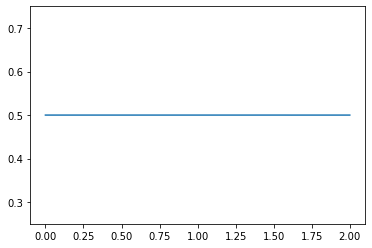

In [35]:
plt.plot(time_space, dms[:, 1, 1])
plt.ylim(0.25, 0.75)

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:473: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2794: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:473: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2794: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, 

Text(0, 0.5, 'L')

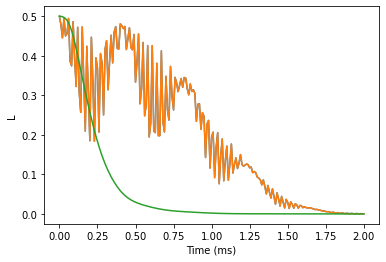

In [45]:
plt.plot(time_space, Lsi_pd)
plt.plot(time_space, Lsi*0.5)
plt.plot(time_space, Lsi_shallow)
plt.xlabel('Time (ms)')
plt.ylabel('L')